    Тестовое задание для стажировки BostonGene, выполнил Сивков Антон

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
gene_train = pd.read_csv('./GSE24080.csv')
annotation_train = pd.read_csv('./GSE24080_annotation.csv')

In [3]:
gene_train.head()

,Unnamed: 0,GSM592391,GSM592392,GSM592393,GSM592394,GSM592395,GSM592396,GSM592397,GSM592398,GSM592399,...,GSM592651,GSM592652,GSM592653,GSM592654,GSM592655,GSM592657,GSM592658,GSM592659,GSM592660,GSM592661
0,1,6.320592,7.841437,7.236905,7.357953,7.575249,6.582377,7.353350,7.851279,6.520901,...,6.557048,6.292696,7.101230,6.475890,7.249549,7.573189,7.019407,7.347394,7.092173,6.567255
1,10,6.524870,6.748844,6.474852,6.531814,6.203069,7.322368,6.201412,6.423229,6.580801,...,6.207441,6.564342,6.480877,6.635799,6.717914,7.153402,7.097871,6.843511,7.213132,6.663122
2,100,6.154809,8.255445,6.606431,6.736690,7.737661,7.210040,8.569865,8.919523,8.794633,...,8.486530,6.867678,5.690035,7.836123,7.102903,6.946071,7.671558,8.236551,8.704792,7.821050
3,1000,7.914991,7.447350,5.754499,6.558732,6.952457,5.911639,7.890182,6.099293,5.991005,...,6.050995,6.069393,5.714169,8.458218,6.148825,7.473370,6.783394,6.987677,7.102996,6.961492
4,10000,5.727344,5.450691,5.591459,5.866231,5.650703,5.682895,5.268059,5.268848,5.765158,...,6.204692,5.810871,6.184398,5.360577,6.343051,5.867253,5.903853,5.619115,5.570919,5.833500


In [4]:
gene_train.shape

(20514, 560)

In [5]:
gene_train = gene_train.T

In [6]:
annotation_train.head()

,Patient,D_Age,D_Gender,D_ISS,HR_FLAG
0,GSM592391,53.356211,Female,1.0,FALSE
1,GSM592392,52.705559,Female,1.0,FALSE
2,GSM592393,62.028826,Male,3.0,FALSE
3,GSM592394,60.312972,Male,1.0,FALSE
4,GSM592395,66.921071,Male,2.0,FALSE


In [7]:
gene_validate = pd.read_csv('./GSE19784.csv')
annotation_validate = pd.read_csv('./GSE19784_annotation.csv')

In [8]:
gene_validate = gene_validate.T
gene_validate.shape

(283, 20514)

In [9]:
X_t = np.array(gene_train.iloc[1:, :])
y_t = preprocessing.LabelEncoder().fit_transform(annotation_train.iloc[:, 4])

In [11]:
np.bincount(y_t)

array([  1, 470,  88])

Видно, что в датасетах есть неразмеченные данные (HR_FLAG = CENSORED), от них можно избавится

In [12]:
mask_cens_t = y_t != 0
X_t = X_t[mask_cens_t]
y_t = y_t[mask_cens_t]
y_t[y_t == 1] = 0
y_t[y_t == 2] = 1

In [13]:
X_v = np.array(gene_validate.iloc[1:, :])
y_v = preprocessing.LabelEncoder().fit_transform(annotation_validate.iloc[:, 4])

In [15]:
np.bincount(y_v)

array([  8, 182,  92])

In [16]:
mask_cens_v = y_v != 0
X_v = X_v[mask_cens_v]
y_v = y_v[mask_cens_v]
y_v[y_v == 1] = 0
y_v[y_v == 2] = 1

Сравнение мат ожиданий в X_t и X_v

In [17]:
np.abs(X_t.mean(axis=0) - X_v.mean(axis=0)).mean()

0.77160209418413728

In [18]:
(X_t.mean(axis=0) - X_v.mean(axis=0)).mean()

0.5777867172490897

In [19]:
((X_t[y_t == 1]).mean(axis=0) - (X_v[y_v == 1]).mean(axis=0)).mean()

0.59252479626665255

In [20]:
((X_t[y_t == 0]).mean(axis=0) - (X_v[y_v == 0]).mean(axis=0)).mean()

0.57169762038263128

Видно, что в обучающей выборке средние значения экспрессии в среднем чуть выше, чем в валидационной, не совсем понятно что это характеризует, не уверен что нужно центрировать данные, т. к. значения экспресии имеют биологический смысл

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Размеры классов

<Container object of 2 artists>

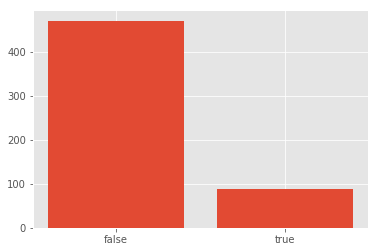

In [22]:
plt.bar(['false', 'true'], np.bincount(y_t))

<Container object of 2 artists>

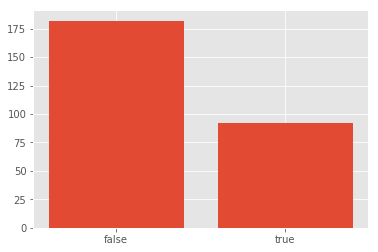

In [23]:
plt.bar(['false', 'true'], np.bincount(y_v))

Если предположить, что признаки получены в одинаковых условиях и имеют схожую природу, по kdeplot случайных признаков выходит, что данные достаточно централизованно распределены и измерения не зашумлены

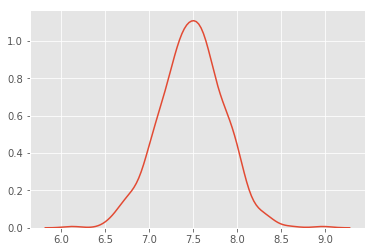

In [24]:
sns.kdeplot(X_t[:, np.random.randint(0, X_t.shape[1])])

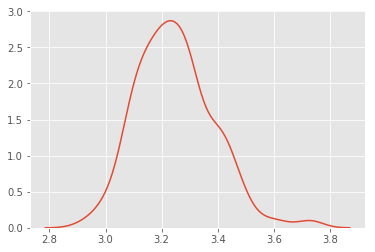

In [25]:
sns.kdeplot(X_v[:, np.random.randint(0, X_v.shape[1])])

Шкалированние и центрирование

In [27]:
scaler = preprocessing.StandardScaler()
X_t_scaled = scaler.fit_transform(X_t)
X_v_scaled = scaler.fit_transform(X_v)

Я хотел отчистить данные от выбросов / похожих объектов, для этого написал небольшой класс, основанный на Local Sensitive Hash и косинусном расстоянии между объектами (позже понял что в данном случае вычислительно проще просто считать расстояния между объектами, но дискретные функции расстояния проще интерпретировать)

In [28]:
class LSH_cleaner:

    def __init__(self, hash_size=256):
        self.hash_size = hash_size
        self.neighbors = None

    def fit(self, X, k_neighbors=1):
        """
        Calculate k nearest neighbors of every X sample
        """
        hashes = np.empty((X.shape[0], self.hash_size), dtype=np.int32)
        
        for i in range(X.shape[0]):
            vectors = np.random.uniform(low=-1.0, high=1.0, size=(self.hash_size, X.shape[1]))
            hashes[i] = (X[i] * vectors).sum(axis=1) > 0

        self.neighbors = np.empty((X.shape[0], k_neighbors * 2), dtype=np.int32)

        for i in range(X.shape[0]):
            dist = np.abs(hashes[i] - hashes).sum(axis=1)
            neigh_args = np.argpartition(dist, k_neighbors + 1)[:(k_neighbors + 1)]
            self.neighbors[i, :k_neighbors] = neigh_args[np.argsort(dist[neigh_args])][1:]
            self.neighbors[i, k_neighbors:] = dist[self.neighbors[i, :k_neighbors]]
        return self.neighbors
    
    def clear_mask(self, n_neighbors, threshold):
        """
        Return mask for X transferred to fit, mask represent dataset with n_neighbors nearest
        neighbors removed for every sample (not for already removed)
        """
        res = np.ones(self.neighbors.shape[0], dtype=np.bool)
        calc_neighbors = self.neighbors.shape[1] // 2
        for i in range(self.neighbors.shape[0]):
            
            for j in range(n_neighbors):
                
                if (self.neighbors[i, j + calc_neighbors] < threshold) and self.neighbors[i, j] > i:
                    res[self.neighbors[i, j]] = False
        return res                    

In [29]:
cln = LSH_cleaner(hash_size=512)
k_neighbors = 2

In [30]:
%time dst = cln.fit(X_t_scaled, k_neighbors)

CPU times: user 1min 25s, sys: 29.5 s, total: 1min 55s
Wall time: 1min 55s


Из графиков ниже видно, что ближайший сосед некоторых объектов значительно ближе, чем второй по дальности, также видно что в датасете нет объектов, далеко отстоящих от остальных

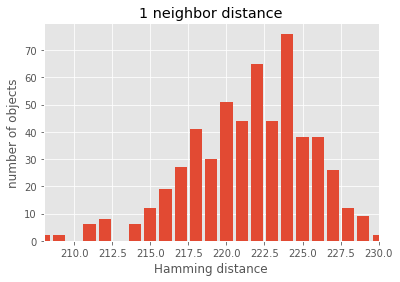

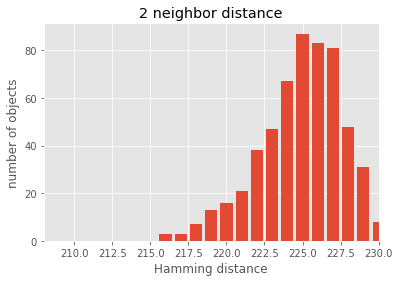

In [31]:
args = np.unique(dst[:, k_neighbors])
xlim = [np.min(args), np.max(args)]

for i in range(2):
    tmp = np.unique(dst[:, i + 2], return_counts=True)
    plt.title('%d neighbor distance' % (i + 1))
    plt.xlabel('Hamming distance')   
    plt.ylabel('number of objects')
    plt.xlim(xlim)
    
    plt.bar(tmp[0], tmp[1])
    plt.figure()

Уберем по 1 объекту из нескольких "близких" пар в обучающей выборке

In [39]:
mask = cln.clear_mask(n_neighbors=1, threshold=214)
X_t_scaled_cleaned = X_t_scaled[mask]
y_t_cleaned = y_t[mask]

In [40]:
X_t_scaled_cleaned.shape

(549, 20514)

    Тестирование svm

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

Функция, рассчитывающая roc auc score для 2 случаев, я решил что roc auc score наиболее подходящая метрика для данной задачи бинарной классификации

In [36]:
def scores(clf, X_t, y_t, X_v, y_v):
    """
    Function that calculate cross_val_score for clf on X_t dataset,
    and roc_auc_score for clf trained on X_t and used on X_v
    """
    res = []
    res.append(cross_val_score(clf, X_t, y_t, scoring='roc_auc').mean())
    clf.fit(X_t, y_t)
    res.append(roc_auc_score(y_v, clf.predict_proba(X_v)[:, 1]))
    return tuple(res)

Тестирование на очищенной и отшкалированной выборке

In [44]:
clf_svm = SVC(probability=True, class_weight='balanced')

In [45]:
%time scores(clf_svm, X_t_scaled_cleaned, y_t_cleaned, X_v_scaled, y_v)

CPU times: user 1min 31s, sys: 189 ms, total: 1min 32s
Wall time: 1min 32s


(0.60422427035330262, 0.61663879598662197)

Отшкалированная и неочищенная выборка

In [46]:
%time scores(clf_svm, X_t_scaled, y_t, X_v_scaled, y_v)

CPU times: user 1min 38s, sys: 170 ms, total: 1min 39s
Wall time: 1min 39s


(0.62818541733542832, 0.62541806020066892)

Центрированая выборка

In [48]:
X_t_centered = X_t - X_t.mean(axis=0)
X_v_centered = X_v - X_v.mean(axis=0)

In [55]:
%time scores(clf_svm, X_t_centered, y_t, X_v_centered, y_v)

CPU times: user 1min 34s, sys: 143 ms, total: 1min 34s
Wall time: 1min 34s


(0.66038612655129236, 0.625)

Выборка без преобразований

In [56]:
%time scores(clf_svm, X_t, y_t, X_v, y_v)

CPU times: user 1min 34s, sys: 131 ms, total: 1min 34s
Wall time: 1min 34s


(0.66038612655129236, 0.63664596273291918)

Как видно, все мои попытки преобразовать данные приводят к ухудшению качества работы svm, возможно
- Шкалирование не работает из-за потери точности
- Центрирование не работает из-за того, что датасеты малы и средние по датасетам не соответствуют биологическим средним
- "Похожие" объекты вносят весомый вклад в результат по отдельности, они не являются дубликатами, либо я использую не совсем подходящий хэш

    Feature Selection

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
clf = RandomForestClassifier(n_estimators=1500)

In [59]:
%time clf_f.fit(X_t, y_t)

CPU times: user 2min 4s, sys: 35.2 ms, total: 2min 4s
Wall time: 2min 4s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
train_imp = np.copy(clf_f.feature_importances_)

Из графика ниже понятно, что целевая переменная в train датасете существенно зависит от числа фичей, значительно меньшего размерности датасета

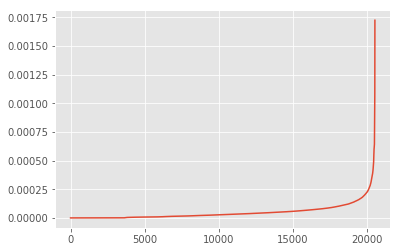

In [64]:
plt.plot(np.arange(train_imp.size), np.sort(train_imp))

In [62]:
(train_imp != 0).sum()

16928

In [63]:
mask_train = train_imp > 0.0002
mask_train.sum()

693

В этом месте я эксперементировал с количеством топ фичей, и заметил, что число фичей обратно пропорционально среднему roc auc кросс валидации на обучающей выборке (меньше фичей давало лучший результат), и прямо пропорционально roc auc на валидационной. После этого я решил сделать возможно не совсем корректную вещь, а именно посчитать feature importance на валидационной выборке

In [65]:
%time clf_f.fit(X_v, y_v)

CPU times: user 26.1 s, sys: 19.8 ms, total: 26.1 s
Wall time: 26.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
validate_imp = np.copy(clf.feature_importances_)

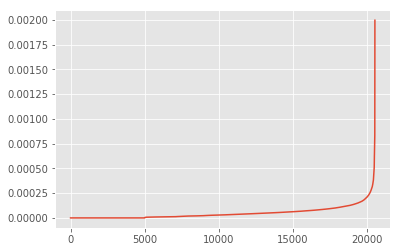

In [67]:
plt.plot(np.arange(validate_imp.size), np.sort(validate_imp))

In [68]:
mask_validate = validate_imp > 0.0002
mask_validate.sum()

605

Из числа ниже видно что топ фичи для обучающей и валидационной выборки слабо пересекаются, т. е. группы риска в тренировочном и валидационном датасетах связаны в значительной степени с разными генами

In [69]:
np.logical_and(mask_train, mask_validate).sum()

43

In [70]:
np.logical_or(mask_train, mask_validate).sum()

1255

 Тут я соединил датасеты для нахождения общих топ фичей, возможно используя далее общие топ фичи я переобучил модель, финальную модель я обучал в 2 видах: на полном датасете и с выделенными фичами

In [71]:
X_ = np.concatenate((X_t, X_v), axis=0)
y_ = np.concatenate((y_t, y_v), axis=0)

In [73]:
%time clf_f.fit(X_, y_)

CPU times: user 3min 3s, sys: 108 ms, total: 3min 3s
Wall time: 3min 3s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Поиск оптимальных фичей

In [75]:
def optimal_features(clf, X_t, y_t, X_v, y_v, imp, sizes):
    """
    Function for founding optimal top features number,
    it optimise sum of two scores
    """
    imp_ind = np.argsort(imp)
    
    scores = np.empty((2, sizes.size))
    
    for i, size in enumerate(sizes):
        features = imp_ind[-1 * size:]
        
        scores[0, i] = cross_val_score(clf, X_t[:, features], y_t, scoring='roc_auc').mean()
        
        clf.fit(X_t[:, features], y_t)
        probas = clf.predict_proba(X_v[:, features])
        scores[1, i] = roc_auc_score(y_v, probas[:, 1])
    
    opt_ind = np.argmax(scores.sum(axis=0))
    return (imp_ind[-1 * sizes[opt_ind]:],
            tuple(scores[:, opt_ind]),
            sizes[opt_ind]
            )

Небольшим ручным перебором подобрался локальный минимум (глобальный не успел подобрать)

In [82]:
sizes = np.array([270, 265, 255, 250, 245], dtype=np.int64)

In [83]:
%time tmp = optimal_features(clf_svm, X_t, y_t, X_v, y_v, clf.feature_importances_, sizes)

CPU times: user 6.14 s, sys: 24.1 ms, total: 6.16 s
Wall time: 6.16 s


In [84]:
print(tmp[1], tmp[2], sep='\n')

(0.70908811885091261, 0.69457716196846631)
255


In [85]:
features_svm = tmp[0]

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

Тестирование и подборка параметров для градиентного бустинга

In [88]:
clf_boost = GradientBoostingClassifier(n_estimators=300)

In [89]:
sizes = np.array([270, 265, 255, 250, 245], dtype=np.int64)

In [90]:
%time tmp = optimal_features(clf_boost, X_t, y_t, X_v, y_v, clf.feature_importances_, sizes)

CPU times: user 55.1 s, sys: 67.7 ms, total: 55.2 s
Wall time: 55.2 s


In [91]:
print(tmp[1], tmp[2], sep='\n')

(0.75883272229637255, 0.72784280936454848)
265


In [93]:
features_boost = tmp[0]

Тестирование Naive Bayes с мультиномиальным распределением

In [94]:
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()

In [98]:
sizes = np.array([285, 280, 275, 270, 265], dtype=np.int64)
tmp = optimal_features(clf_nb, X_t, y_t, X_v, y_v, clf.feature_importances_, sizes)
print(tmp[1], tmp[2], sep='\n')

(0.70595728185229623, 0.68597706641184908)
280


In [99]:
features_nb = tmp[0]

Для упрощения построения ансамбля алгоритмов я буду оптимизировать алгоритмы с общими фичами

In [100]:
features = features_boost

    Аннотации

- Пол

In [101]:
gender_t = preprocessing.LabelEncoder().fit_transform(annotation_train.iloc[:, 2])[mask_cens_t]

In [102]:
X_t_male = X_t[gender_t == 1][:, features]
y_t_male = y_t[gender_t == 1]
X_t_female = X_t[gender_t == 0][:, features]
y_t_female = y_t[gender_t == 0]
X_t_ext = np.concatenate((X_t[:, features], np.vstack(gender_t)), axis=1)

В валидационной выборке есть пропуски в поле "D_gender"

In [103]:
na_gender_mask = np.array(annotation_validate.iloc[:, 2].notna())[mask_cens_v]
tmp_mask = np.logical_and(np.array(annotation_validate.iloc[:, 2].notna()), mask_cens_v)
gender_v = preprocessing.LabelEncoder().fit_transform(annotation_validate.iloc[:, 2][tmp_mask])

In [104]:
X_v_male = X_v[na_gender_mask][gender_v == 1][:, features]
y_v_male = y_v[na_gender_mask][gender_v == 1]
X_v_female = X_v[na_gender_mask][gender_v == 0][:, features]
y_v_female = y_v[na_gender_mask][gender_v == 0]
X_v_ext = np.concatenate((X_v[na_gender_mask][:, features], np.vstack(gender_v)), axis=1)
y_v_ext = y_v[na_gender_mask]

svm, достаточно странные значения roc_auc

In [105]:
scores(clf_svm, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70725810539120448, 0.68729096989966554)

In [106]:
scores(clf_svm, X_t_male, y_t_male, X_v_male, y_v_male)

(0.7322120486865894, 0.58139534883720934)

In [107]:
scores(clf_svm, X_t_female, y_t_female, X_v_female, y_v_female)

(0.61903792145727632, 0.77025300281114228)

Бустинг

In [108]:
scores(clf_boost, X_t[:, features], y_t, X_v[:, features], y_v)

(0.74791665493400616, 0.71924271380793114)

In [109]:
scores(clf_boost, X_t_ext, y_t, X_v_ext, y_v_ext)

(0.7527265764472002, 0.70748428870691293)

Naive Bayes

In [110]:
scores(clf_nb, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70465580128439775, 0.68555900621118016)

In [111]:
scores(clf_nb, X_t_male, y_t_male, X_v_male, y_v_male)

(0.7444684754578702, 0.63751263902932254)

In [112]:
scores(clf_nb, X_t_female, y_t_female, X_v_female, y_v_female)

(0.64872030597837049, 0.74495272169690774)

- Возраст

In [113]:
age_t = annotation_train.iloc[:, 1][mask_cens_t]

In [114]:
X_t_ext = np.concatenate((X_t[:, features], np.vstack(np.array(age_t))), axis=1)

В валидационной выборке возраста нет - для тестирования можно заполнить средним по обучающей

In [115]:
X_v_ext = np.concatenate((X_v[:, features], np.vstack(np.repeat(age_t.mean(), X_v.shape[0]))), axis=1)

In [116]:
scores(clf_svm, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70725810539120448, 0.68729096989966554)

In [117]:
scores(clf_svm, X_t_ext, y_t, X_v_ext, y_v)

(0.72522493856778947, 0.67940754897276634)

In [118]:
scores(clf_boost, X_t[:, features], y_t, X_v[:, features], y_v)

(0.75653021113157293, 0.71040372670807461)

In [119]:
scores(clf_boost, X_t_ext, y_t, X_v_ext, y_v)

(0.75438491761795079, 0.70938843764930715)

In [120]:
scores(clf_nb, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70465580128439775, 0.68555900621118016)

In [121]:
scores(clf_nb, X_t_ext, y_t, X_v_ext, y_v)

(0.70505471174260992, 0.68747013855709505)

In [122]:
X_t_age = np.copy(X_t_ext)
X_v_age = np.copy(X_v_ext)

- стадия заболевания (D_ISS)

In [123]:
d_iss_t = np.array(annotation_train.iloc[:, 3][mask_cens_t], dtype=np.int64)
d_iss_v = np.array(annotation_validate.iloc[:, 3][mask_cens_v], dtype=np.int64)

In [124]:
X_t_ext = np.concatenate((X_t[:, features], np.vstack(d_iss_t)), axis=1)
X_v_ext = np.concatenate((X_v[:, features], np.vstack(d_iss_v)), axis=1)

In [125]:
scores(clf_boost, X_t[:, features], y_t, X_v[:, features], y_v)

(0.75887345809375228, 0.72013855709507879)

In [126]:
scores(clf_boost, X_t_ext, y_t, X_v_ext, y_v)

(0.75699388587594163, 0.72264691829909222)

In [127]:
scores(clf_svm, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70725810539120448, 0.68729096989966554)

In [129]:
for i in range(1, 4):
    mask = X_t_ext[:, -1] == i
    print(scores(clf_svm, X_t_ext[mask], y_t[mask], X_v_ext, y_v))

(0.72590275413309124, 0.66925465838509313)
(0.77834757834757839, 0.69332298136645965)
(0.56980146290491118, 0.67689918776875302)


In [130]:
scores(clf_nb, X_t[:, features], y_t, X_v[:, features], y_v)

(0.70465580128439775, 0.68555900621118016)

In [131]:
for i in range(1, 4):
    mask = X_t_ext[:, -1] == i
    print(scores(clf_nb, X_t_ext[mask], y_t[mask], X_v_ext, y_v))

(0.69546967805394766, 0.6209985666507406)
(0.74328110161443484, 0.6746894409937888)
(0.5845350052246604, 0.67797419971333006)


Исходя из полученных значений roc-auc, имеет смысл использовать возраст в качестве дополнительного признака

    Подбор гиперпараметров

In [132]:
def optimal_parameter(clf_class, X_t, y_t, X_v, y_v, param, fix_params=''):
    """
    Function for hyperparameter selection based on two scores,
    only one parameter selection is available.
    
    parameters:
        
        clf_class - sklearn-like ML class (not instance, class object!)
        
        param - dict with one key, representing parameter to
        select and selection list
        
        fix_params - string with fixed parameters of clf_class
    """
    assert len(param) == 1, "Selection of one parameter is available"
    
    pr = list(param.items())[0]
    scores = np.empty((2, len(pr[1])))
    
    for i, value in enumerate(pr[1]):
        clf = eval('clf_class(%s, %s)' % (pr[0] + ('=' + str(value)), fix_params))
        scores[0, i] = cross_val_score(clf, X_t, y_t, scoring='roc_auc').mean()
        
        clf.fit(X_t, y_t)
        scores[1, i] = roc_auc_score(y_v, clf.predict_proba(X_v)[:, 1])
    
    opt_ind = np.argmax(scores.sum(axis=0))
    return (
            eval('clf_class(%s, %s)' % ((pr[0] + ('=%f' % pr[1][opt_ind])), fix_params)),
            tuple(scores[:, opt_ind]),
            pr[1][opt_ind]
            )

In [133]:
param = {
    "C": np.arange(1, 1000) * 0.001
}

In [134]:
%time tmp = optimal_parameter(SVC, X_t_age, y_t, X_v_age, y_v, param, 'probability=True, class_weight="balanced"')

CPU times: user 20min 43s, sys: 353 ms, total: 20min 44s
Wall time: 20min 44s


In [135]:
print(tmp[1], tmp[2], sep='\n')

(0.7296230906268244, 0.68597706641184897)
0.334


In [137]:
svm_param = tmp[2]

In [136]:
param = {
    "alpha": np.arange(1, 1000) * 0.001
}

In [138]:
%time tmp = optimal_parameter(MultinomialNB, X_t_age, y_t, X_v_age, y_v, param, '')

CPU times: user 27.6 s, sys: 1.01 s, total: 28.6 s
Wall time: 14.3 s


In [139]:
print(tmp[1], tmp[2], sep='\n')

(0.70542499450911489, 0.68764930721452466)
0.001


In [140]:
nb_param = tmp[2]

In [141]:
param = {
    "n_estimators": np.int64(np.arange(725, 735))
}

In [142]:
%time tmp = optimal_parameter(GradientBoostingClassifier, X_t_age, y_t, X_v_age, y_v, param, '')

CPU times: user 4min 21s, sys: 23.8 ms, total: 4min 21s
Wall time: 4min 21s


In [143]:
print(tmp[1], tmp[2], sep='\n')

(0.75405771718093251, 0.71297181079789784)
725


In [144]:
boost_param = tmp[2]

In [145]:
clf_svm = SVC(C=svm_param, probability=True, class_weight='balanced')
clf_nb = MultinomialNB(alpha=nb_param)
clf_boost = GradientBoostingClassifier(n_estimators=boost_param)

    VotingClassifier от svm, Naive Bayes, Gradient Boosting

In [146]:
from sklearn.ensemble import VotingClassifier

In [157]:
estimators = [
    ('svm', clf_svm),
    ('nb', clf_nb),
    ('boost', clf_boost)
]
clf_vote = VotingClassifier(estimators, voting='soft', n_jobs=3)

In [158]:
%time scores(clf_vote, X_t_age, y_t, X_v_age, y_v)

CPU times: user 1.08 s, sys: 340 ms, total: 1.42 s
Wall time: 28 s


(0.74321946082323853, 0.7004897276636407)

In [159]:
from sklearn.metrics import roc_curve, auc

RОС кривая на валидационной выборке при обучении на датасете с возрастом

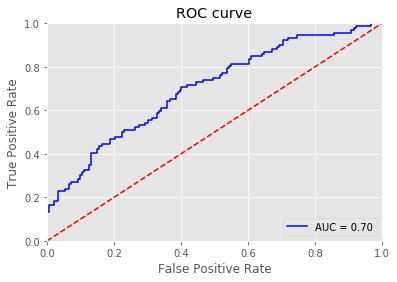

In [165]:
clf_vote.fit(X_t_age, y_t)
probas = clf_vote.predict_proba(X_v_age)[:, 1]
fpr, tpr, threshold = roc_curve(y_v, probas)
roc_auc = auc(fpr, tpr)

plt.title('RОС curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [149]:
%time scores(clf_vote, X_t[:, features], y_t, X_v[:, features], y_v)

CPU times: user 1.25 s, sys: 332 ms, total: 1.58 s
Wall time: 26.5 s


(0.72304716904980471, 0.69833970377448629)

RОС кривая на валидационной выборке при обучении на датасете без возраста, заметной разницы с предыдущей кривой не должно быть

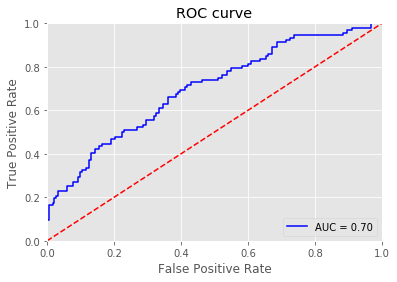

In [166]:
clf_vote.fit(X_t[:, features], y_t)
probas = clf_vote.predict_proba(X_v[:, features])[:, 1]
fpr, tpr, threshold = roc_curve(y_v, probas)
roc_auc = auc(fpr, tpr)

plt.title('RОС curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Обучение на полной выборке

In [169]:
estimators = [
    ('svm', clf_svm),
    ('nb', clf_nb)
]
clf_vote = VotingClassifier(estimators, voting='soft', n_jobs=3)

In [152]:
%time scores(clf_vote, X_t, y_t, X_v, y_v)

CPU times: user 11.7 s, sys: 997 ms, total: 12.7 s
Wall time: 1min 51s


(0.66837390956652987, 0.60015527950310554)

RОС кривая на валидационной выборке при обучении на полном датасете

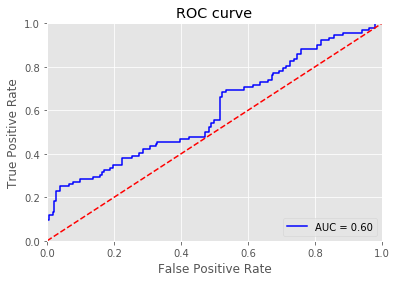

In [170]:
clf_vote.fit(X_t, y_t)
probas = clf_vote.predict_proba(X_v)[:, 1]
fpr, tpr, threshold = roc_curve(y_v, probas)
roc_auc = auc(fpr, tpr)

plt.title('RОС curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()